In [1]:
!pip install -U git+https://github.com/d2l-ai/d2l-en.git@master

  Cloning https://github.com/d2l-ai/d2l-en.git (to revision master) to /tmp/pip-req-build-s3vj2hgm
  Running command git clone -q https://github.com/d2l-ai/d2l-en.git /tmp/pip-req-build-s3vj2hgm
  Created wheel for d2l: filename=d2l-0.15.1-cp36-none-any.whl size=62959 sha256=301fea5047b03648ea0bd9e4fb5a06fcd712aca69609776c896d56df44b0d2e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-j85vxom8/wheels/0f/41/8f/72ece70ede8a0e37eec72c03087eb4604925ba212b804f8cad
Successfully built d2l
  Found existing installation: d2l 0.15.1
    Uninstalling d2l-0.15.1:
      Successfully uninstalled d2l-0.15.1


In [2]:
from d2l import torch as d2l
import torch
from torch import nn

In [3]:
#@save
def resnet18(num_classes, in_channels=1):
    """A slightly modified ResNet-18 model."""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the maximum pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [4]:
net = resnet18(10)
# get a list of GPUs
devices = d2l.try_all_gpus()
# we'll initialize the network inside the training loop

In [5]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # Set model on multiple gpus
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

test acc: 0.92, 47.3 sec/epoch on [device(type='cuda', index=0)]


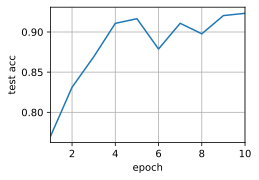

In [6]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

In [7]:
train(net, num_gpus=2, batch_size=512, lr=0.2)

ValueError: ignored